<a href="https://colab.research.google.com/github/begum4ozcan/corporate-sustainability.dsa210/blob/main/ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error


url = "https://raw.githubusercontent.com/begum4ozcan/corporate-sustainability.dsa210/main/data/raw/epi2024results.csv"
df = pd.read_csv(url)


In [3]:
target = "EPI.new"

feature_cols = [
    c for c in df.columns
    if c.endswith(".new") and c != target
]

X = df[feature_cols]
y = df[target]

X.shape, y.shape

((180, 72), (180,))

In [4]:
rmse = make_scorer(
    lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)),
    greater_is_better=False,
)

In [5]:
models = {
    "Ridge Regression": Ridge(alpha=2.0),
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    scores = cross_validate(
        pipe, X, y,
        cv=cv,
        scoring={"rmse": rmse, "r2": "r2"}
    )

    results.append({
        "Model": name,
        "RMSE": -scores["test_rmse"].mean(),
        "R2": scores["test_r2"].mean()
    })

pd.DataFrame(results)


,Model,RMSE,R2
0,Ridge Regression,0.440527,0.998408
1,Random Forest,3.079452,0.925350


**Machine Learning Results:**

Random Forest outperforms Ridge Regression, suggesting that the relationship between environmental indicators and EPI scores is nonlinear. This highlights the complexity of environmental performance drivers across countries.

Since EPI is a composite index constructed from several environmental indicators, high predictive performance - especially for linear models - is expected. The purpose of the model is not causal inference, but to demonstrate how component indicators relate to the final index score.

<Axes: title={'center': 'Top Drivers of EPI (New)'}>

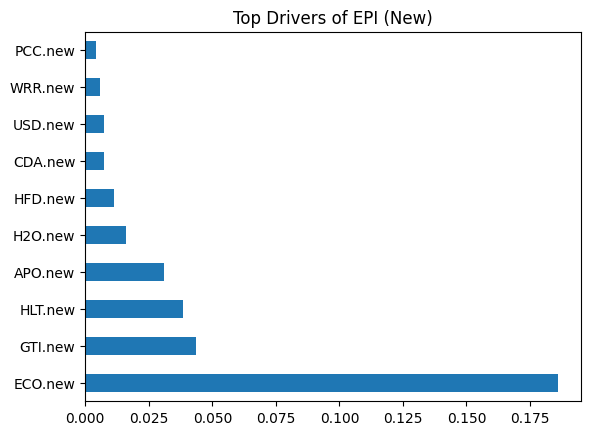

In [6]:
from sklearn.inspection import permutation_importance

rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipe.fit(X, y)

perm = permutation_importance(
    rf_pipe, X, y,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = (
    pd.Series(perm.importances_mean, index=X.columns)
      .sort_values(ascending=False)
      .head(10)
)

importances.plot(kind="barh", title="Top Drivers of EPI (New)")


*Explanation:*

*Ridge Regression achieves near-perfect performance because the EPI is a compsite index constructed directly from many of the predictor variables used in the model. This result is therefore expected and reflects the internal consistency of the index rather than causal relationships. Random Forest performs slightly worse, indicating that the underlying relationship between indicators and EPI is linear.*
